# Persistent Homology of Collocations and Multiword Expressions Across Contexts for Hebrew

This notebook is for comparing how well two models preserves the persistent homology of some keyphrase like a collocation, multiword expression, or idiom. We take such a keyphrase and place it in several different contexts `text[i]`, then compute the persistent homology of the context vectors in each context. Once this is complete, we compute the pairwise distances between the persistent diagrams using the Wasserstein distance metric. This gives two distance matrices, one for each mode (here we use `xlm-roberta-large` and `TurkuNLP/wikibert-base-he-cased`). Once we have computed this distance matrix, we do a simple elementwise comparison to see what percentage of the elements in the difference of the two distance matrices are negative. Note that this is a per attention head comparison, so we can compare different attention heads in each model. Changing the second function `compute_output_b()` to use the first model `xlm-roberta-large` allows for comparing different attention heads *within the same model*. 

In [1]:
pip install transformers torch numpy gudhi -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
text = ["בחופשה האחרונה שלנו, נסענו להכיר את היופיים של מדבר הנגב. בין אם מדובר בצוקים המרשימים, בחי הבר המיוחד, או בשקט המוחלט, יש משהו מאוד מיוחד במדבר. אחת החוויות המרגשות ביותר שלנו הייתה לצפות בזרחת השמש מעל המדבר. האור המתפשט מאחורי ההרים, השמים המשתנים מאוד מהיר מאופל לתכלת, והשלווה המוחלטת שאפשר רק במדבר, הכל הפך את החוויה לבלתי נשכחת", 
          
          "במהלך שנת הלימודים הראשונה שלי באוניברסיטה, הצטרפתי לקבוצת טיול שהגיעה להר האייפל. למרות הקור החודר, הייתי מחויב לעלות לפסגה בכל בוקר, כדי לצפות בזרחת השמש מעל פריס", 
          
          "הייתי מתעורר בבוקר מוקדם, לפני כולם, כדי לצפות בזרחת השמש. היו ימים שהשמים היו מלאים בגוונים של ורוד וכתום, והאוויר הקר היה ממלא את הריאות. הייתי נושם את השקט, מאזין לשירת הציפורים, ומרגיש את היום החדש שמתחיל.", 
          
          "הייתה לי הרגל לצפות בזרחת השמש כאשר הייתי טסה למקומות רחוקים. הייתי מתמקדת באור הזהב של השמש שהתפשט על פני האופק. זה היה רגע של שקט ושלווה, שבו הייתי מרגישה את האפשרויות של היום שלפני.", 
          
          "אחד הדברים שאני ממש אוהב לעשות בחופשות הוא לצפות בזרחת השמש על גג המלון. אין דבר יותר מרגיע מאשר לשבת עם כוס קפה ביד, להתבונן בנוף, ולראות איך העולם מתעורר לחיים.", 
          
          "במהלך ההליכה, עצרנו לרגע כדי לצפות בזרחת השמש. האור הראשוני של היום הזהיר את השמיים בצבעים של זהב, ואנחנו ישבנו שם בשקט, מתפללים ליום טוב.", 
          
          "אני מאמין שאין דבר מרגש יותר מ לצפות בזרחת השמש. כאשר האור הראשונים מתחילים להתפשט באופק, אתה מרגיש כאילו אתה חלק ממשהו גדול מאוד. זה מזכיר לי כמה העולם הזה גדול ויפה.", 
          
          "אחת הפעמים המיוחדות ביותר שבהן הזמנתי לצפות בזרחת השמש הייתה בחופשה שלי בהודו. הייתי מתעורר מוקדם, לפני כל העולם, ומשתקף למראה המרהיבה של השמש המתעלה מעל האוקיינוס. זה היה חוויה שאני לעולם לא אשכח.", 
          
          "אני אוהב לצפות בזרחת השמש מהחלון שלי. זה נותן לי את האנרגיה להתחיל את היום. אני אפילו מקדיש כמה דקות בכל בוקר לקחת כוס קפה, לשבת מול החלון, ולהשתקף במראה המדהים הזה.", 
          
          "בראשית, אני אוהב לצפות בזרחת השמש מהמרפסת שלי. זה מזכיר לי את היופי של העולם, את התקווה של יום חדש, ואת החיים הממשיכים להתפתח בכל יום. כל זריחה מציגה תמונה שונה, נוף חדש שממלא אותי בתחושת התרגשות והתפעלות.", 
          
          "היום האחרון שלי ביפן היה יום מיוחד. יצאתי להליך מוקדם בבוקר, כדי לצפות בזרחת השמש מעל הר הפוג'. האור הראשוני של היום מאיר את השיחים המקופים בשלג, מצייר תמונה יפהפיה שאני לעולם לא אשכח.", 
          
          "אחד החוויות המרגשות ביותר שלי היתה לצפות בזרחת השמש מעל הפירמידות במצרים. האור החום החודר את השחקים, מאיר את האבנים העתיקות, ומעניק להם מראה של זהב. זה היה רגע של התבוננות והתפעלות על ההיסטוריה שלנו.", 
          
          "כאשר אני מטייל בים, אני מתכנן לצפות בזרחת השמש מהחוף. אין דבר מרהיב יותר מלראות את האור הראשון של היום מתפשט על גלי הים, משנה את צבעם לגוונים של זהב ואורנג'. זה הופך את החוויה של ההליכה למשהו יוצא דופן.", 
          
          "האלפים היה חלום שלי. כשהגעתי לשם, הייתי עייף אבל מרוצה. לצפות בזרחת השמש מהפסגה, כשהאור העדין של השחר התחיל להתפשט על השפעי השלג הלבנים, היה חוויה בלתי נשכחת. העולם התמלא בנופים שלא ראיתי מעולם. זה היה מרגע של שלווה ושקט, שהיה שווה את כל המאמץ.", 
          
          "אחרי שהוא התעורר מהשנה, איזיק הכין לעצמו כוס קפה והולך להסתובב בגן הפרטי שלו. זו הייתה הדרך האהובה עליו להתחיל את היום - לצפות בזרחת השמש ולשמוע את הציפורים מצפצפות.", 
          
          "את חייבת לצפות בזרחת השמש מהחוף שלנו, אמר יגאל למרים, כאשר הם הגיעו לבית הנופש של המשפחה. זו תחוויה בלתי נשכחת, משהו שתזכורי לעוד שנים.",
          
          "בזמן שהכל בעיר עדיין ישן, רבקה מתעוררת בשעה המוקדמת ביותר שאפשר, מתארגנת, ויוצאת לרוץ. היא אוהבת את השקט של אותן שעות, והמראה של העיר שמתעוררת לחיים. אבל מעל כל, זה הזמן היחיד שהיא יכולה לצפות בזרחת השמש בלי להיות מופרעת.",

          "לשפת האגם הגיעה מיה, המצלמה שלה כבר מוכנה לפעולה. היא התיישבה בשקט, מצפה לרגע הנכון. היא יודעת שממש בקרוב, היא תהיה מסוגלת לצפות בזרחת השמש, והיא רוצה לתפוס את הרגע המושלם בתמונה."

]


In [3]:
for i in range(len(text)):
    print(i, text[i])

0 בחופשה האחרונה שלנו, נסענו להכיר את היופיים של מדבר הנגב. בין אם מדובר בצוקים המרשימים, בחי הבר המיוחד, או בשקט המוחלט, יש משהו מאוד מיוחד במדבר. אחת החוויות המרגשות ביותר שלנו הייתה לצפות בזרחת השמש מעל המדבר. האור המתפשט מאחורי ההרים, השמים המשתנים מאוד מהיר מאופל לתכלת, והשלווה המוחלטת שאפשר רק במדבר, הכל הפך את החוויה לבלתי נשכחת
1 במהלך שנת הלימודים הראשונה שלי באוניברסיטה, הצטרפתי לקבוצת טיול שהגיעה להר האייפל. למרות הקור החודר, הייתי מחויב לעלות לפסגה בכל בוקר, כדי לצפות בזרחת השמש מעל פריס
2 הייתי מתעורר בבוקר מוקדם, לפני כולם, כדי לצפות בזרחת השמש. היו ימים שהשמים היו מלאים בגוונים של ורוד וכתום, והאוויר הקר היה ממלא את הריאות. הייתי נושם את השקט, מאזין לשירת הציפורים, ומרגיש את היום החדש שמתחיל.
3 הייתה לי הרגל לצפות בזרחת השמש כאשר הייתי טסה למקומות רחוקים. הייתי מתמקדת באור הזהב של השמש שהתפשט על פני האופק. זה היה רגע של שקט ושלווה, שבו הייתי מרגישה את האפשרויות של היום שלפני.
4 אחד הדברים שאני ממש אוהב לעשות בחופשות הוא לצפות בזרחת השמש על גג המלון. אין דבר יותר מרגיע מא

## Computing Context Vectors for Specific Attention Heads

Here we define a function `compute_output()` that will compute the context vectors for a specific attention head in a specific layer of the `dicta-il/alephbertgimmel-base` model. The formuala for the context vector for a specific `head` and a specific `layer` is:

$$
\mathbf{c}_{i}^{l,h} = \sum_{j=1}^{n} a_{i, j}^{l,h} \mathbf{v}_{j}^{l,h}
$$

where we compute the attention matrix as:

$$
a_{ij}^{l,h} = \frac{\exp(\mathbf{q}_i^{l,h} \cdot \mathbf{k}_j^{l,h} / \sqrt{d})}{\sum_{m=1}^{n} \exp(\mathbf{q}_i^{l,h} \cdot \mathbf{k}_m^{l,h} / \sqrt{d})}
$$

and the query, key, and value vectors are computed as:

$$\mathbf{q}_i^{l,h} = W_Q^{l, h} \mathbf{x}_i$$
$$\mathbf{k}_i^{l,h} = W_K^{l, h} \mathbf{x}_i$$
$$\mathbf{v}_i^{l,h} = W_V^{l, h} \mathbf{x}_i$$

Here we have used superscript $l$ to denote the `layer` and superscript $h$ to denote the `head`. 

In [4]:
import torch
from transformers import BertTokenizer, BertModel
from transformers import BertModel, BertTokenizerFast
from transformers import AutoTokenizer, AutoModel
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer

def compute_output(sentence, layer, head):
    # Load pre-trained model
    tokenizer = AutoTokenizer.from_pretrained('dicta-il/alephbertgimmel-base')
    model = AutoModel.from_pretrained("dicta-il/alephbertgimmel-base", output_attentions=True) 

    # Tokenize input and convert to tensor
    inputs = tokenizer(sentence, return_tensors="pt")

    # Forward pass
    # Specify `output_hidden_states=True` when calling the model
    outputs = model(**inputs, output_attentions=True, output_hidden_states=True)

    # Obtain the attention weights
    attentions = outputs.attentions

    # Obtain the attention weights for the specific layer and head
    S = attentions[layer][0, head]

    # Obtain the value vectors
    model.eval()
    with torch.no_grad():
        hidden_states = outputs.hidden_states[layer]
        all_W_v = model.encoder.layer[layer].attention.self.value.weight
        num_heads = model.config.num_attention_heads
        head_dim = model.config.hidden_size // num_heads
        W_v_heads = all_W_v.view(num_heads, head_dim, model.config.hidden_size)
        W_v = W_v_heads[head]
        V = torch.matmul(hidden_states, W_v.t())

    # Compute the output O (context vector)
    O = torch.matmul(S, V)

    return O

In [5]:
# Set the layer and head to use for computation
layer = 7
head = 3

context = []
for i in range(len(text)):
    context.append(compute_output(text[i], layer, head))

Some weights of the model checkpoint at dicta-il/alephbertgimmel-base were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at dicta-il/alephbertgimmel-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.poole

### Printing the Context Vectors

Here we see the $64$-dimensional context vectors computed by `head` $3$ in `layer` $7$ of `dicta-il/alephbertgimmel-base`. 

In [6]:
print(context[17].shape)
print(context[17])

torch.Size([1, 42, 64])
tensor([[[-2.0616e-02,  1.7821e-02, -2.4169e-02,  ..., -5.7890e-03,
           9.1376e-03, -7.1004e-02],
         [-2.0414e-02, -1.3651e-03,  4.6301e-03,  ..., -2.8185e-02,
           5.8169e-03, -2.0762e-02],
         [-2.5189e-02,  1.1930e-02,  8.0422e-03,  ..., -7.1751e-03,
           4.9910e-03, -1.1122e-02],
         ...,
         [-9.7359e-02, -8.6875e-02,  8.9944e-02,  ...,  1.4951e-02,
           1.0156e-01,  1.3497e-02],
         [-4.2770e-02, -9.3257e-03,  9.1281e-05,  ..., -4.9319e-04,
           8.1898e-03, -3.0629e-02],
         [-1.8208e-02,  1.5380e-03,  8.7630e-03,  ..., -1.8612e-02,
           2.7136e-03, -1.5271e-02]]], grad_fn=<CloneBackward0>)


## Computing Phrase Distances and Persistant Homology

Here we define a function `compute_phrase_distances_and_homology()` that computes the pairwise distances between the context vectors associated to some subset of the text like a keyphrase, multiword expressions, collocation, or idiom. Once the pairwise distances are computed the persistent homology of the distance matrix is computed. The comments for the print statements can be removed for printing the context vectors of the subset text, the distance matrix of distances between those context vectors, or the barcode diagram for the subset text. 

In [7]:
from scipy.spatial import distance_matrix
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer

def compute_phrase_distances_and_homology(context_vectors, sentence, phrase):
    # Initialize the tokenizer
    tokenizer = AutoTokenizer.from_pretrained('dicta-il/alephbertgimmel-base')

    # Tokenize the sentence and the phrase
    sentence_tokens = tokenizer.encode(sentence, add_special_tokens=False)
    phrase_tokens = tokenizer.encode(phrase, add_special_tokens=False)

    # Find the indices of the phrase tokens in the sentence
    phrase_indices = []
    phrase_length = len(phrase_tokens)
    for i in range(len(sentence_tokens) - phrase_length + 1):
        if sentence_tokens[i:i+phrase_length] == phrase_tokens:
            phrase_indices.extend(range(i, i+phrase_length))
            break

    # Extract the context vectors for the phrase
    phrase_context_vectors = context_vectors[0, phrase_indices]

    # Detach the tensor and convert to numpy array
    phrase_context_vectors_np = phrase_context_vectors.detach().numpy()

    # Print the tokens of the sub-collection and their context vectors
    # print(f'Tokens of the sub-collection: {tokenizer.convert_ids_to_tokens(phrase_tokens)}')
    # print(f'Context vectors of the sub-collection: {phrase_context_vectors_np}')

    # Compute the pairwise Euclidean distances among the phrase context vectors
    distances = distance_matrix(phrase_context_vectors_np, phrase_context_vectors_np)

    # Print the distance matrix
    # print(f'Distance matrix: {distances.shape}')
    # print(f'Distance matrix: {distances}')

    # Compute the persistent homology of the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distances, max_edge_length=np.max(distances))
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistent_homology = simplex_tree.persistence(min_persistence=0.001)

    # Plot the barcode diagram
    # gd.plot_persistence_barcode(persistence=persistent_homology)
    # plt.show()

    return persistent_homology

The following code builds a list of persistent homologies from the list `text` provided at the beginning of the notebook. 

In [8]:
persistent_homology = []
for i in range(len(text)):
    persistent_homology.append(compute_phrase_distances_and_homology(context[i], text[i], "לצפות בזרחת השמש"))

In [9]:
print(persistent_homology[17])

[(0, (0.0, inf)), (0, (0.0, 0.08879990009235991)), (0, (0.0, 0.06385516546010954)), (0, (0.0, 0.043871371912944594))]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


<Axes: title={'center': 'Persistence barcode'}>

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


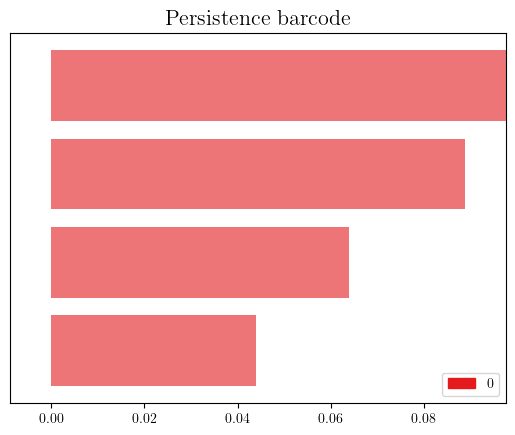

In [10]:
gd.plot_persistence_barcode(persistence=persistent_homology[17])

## Computing Wasserstein Distances Between Persistence Diagrams

Here we define a function `compute_wasserstein_distances()` that computes the pairwise Wasserstein distances between the persistence diagrams of the context vectors of the subset text "לצפות בזרחת השמש" contained in each `text[i]`. Note, the context vectors for the phrase "לצפות בזרחת השמש" change depending on the context `text[i]`. However, quite interestingly, their persistent homology remains relatively stable for some models. In our examples here, we show that for `head` $3$ of `layer` $7$, the model `TurkuNLP/wikibert-base-he-cased` preserves the persistent homology quite well compared to `dicta-il/alephbertgimmel-base`. This is discovered by computing the distance matrix of Wasserstein distances between persistence diagrams for the context vectors of the phrase "לצפות בזרחת השמש" in the various contexts `text[i]`. 

In [11]:
from gudhi.hera import wasserstein_distance
import numpy as np

def transform_persistence_diagram(diagram):
    # Remove the dimension from each feature and return the transformed diagram
    return [(birth, death) for dimension, (birth, death) in diagram]

def compute_wasserstein_distances(persistence_diagrams, p=2):
    n = len(persistence_diagrams)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            diagram1 = transform_persistence_diagram(persistence_diagrams[i])
            diagram2 = transform_persistence_diagram(persistence_diagrams[j])
            distance = wasserstein_distance(diagram1, diagram2, order=1., internal_p=2.)
            distances[i, j] = distance
            distances[j, i] = distance
    return distances

In [12]:
persistence_diagrams_1 = []
for i in range(len(text)):
    persistence_diagrams_1.append(persistent_homology[i])

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

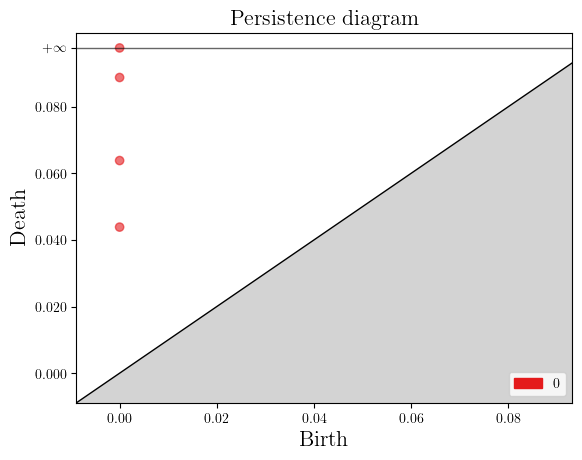

In [13]:
gd.plot_persistence_diagram(persistence = persistence_diagrams_1[17])

### The Distance Matrix of Wasserstein Distances

Here we compute and print the pairwise Wasserstein distances between each pair of persistence diagrams for the phrase "לצפות בזרחת השמש" in the contexts `text[i]` for the context vectors computed by `dicta-il/alephbertgimmel-base`. 

In [14]:
w_distances = compute_wasserstein_distances(persistence_diagrams_1)
print(w_distances)

[[0.         0.03906409 0.06768252 0.01582506 0.03770175 0.0536398
  0.15329609 0.05936641 0.04858733 0.03164361 0.03303008 0.02787108
  0.09350701 0.01599855 0.05179377 0.03987738 0.02598949 0.0275382 ]
 [0.03906409 0.         0.0645027  0.02323903 0.03355226 0.06028298
  0.16411771 0.0984305  0.06301441 0.03404442 0.04729481 0.05920674
  0.09032718 0.03538052 0.06622085 0.07894147 0.0342514  0.03392753]
 [0.06768252 0.0645027  0.         0.0544742  0.04581725 0.0742778
  0.18692717 0.11924284 0.05710626 0.03603891 0.03465244 0.0955536
  0.02824927 0.05168397 0.07092672 0.10226097 0.05484828 0.09522072]
 [0.01582506 0.02323903 0.0544742  0.         0.02289191 0.051782
  0.16650441 0.07519147 0.04934628 0.01843529 0.02769542 0.0410794
  0.08029869 0.0121415  0.05255272 0.05570245 0.0251905  0.04074652]
 [0.03770175 0.03355226 0.04581725 0.02289191 0.         0.06950677
  0.17944204 0.09706816 0.0722382  0.01999684 0.01858499 0.0578444
  0.06736106 0.03491781 0.07544464 0.07757913 0.013

---

## Computing Context Vectors for Specific Attention Heads

Here we define a function `compute_output()` that will compute the context vectors for a specific attention head in a specific layer of the `TurkuNLP/wikibert-base-he-cased` model. The formuala for the context vector for a specific `head` and a specific `layer` is:

$$
\mathbf{c}_{i}^{l,h} = \sum_{j=1}^{n} a_{i, j}^{l,h} \mathbf{v}_{j}^{l,h}
$$

where we compute the attention matrix as:

$$
a_{ij}^{l,h} = \frac{\exp(\mathbf{q}_i^{l,h} \cdot \mathbf{k}_j^{l,h} / \sqrt{d})}{\sum_{m=1}^{n} \exp(\mathbf{q}_i^{l,h} \cdot \mathbf{k}_m^{l,h} / \sqrt{d})}
$$

and the query, key, and value vectors are computed as:

$$\mathbf{q}_i^{l,h} = W_Q^{l, h} \mathbf{x}_i$$
$$\mathbf{k}_i^{l,h} = W_K^{l, h} \mathbf{x}_i$$
$$\mathbf{v}_i^{l,h} = W_V^{l, h} \mathbf{x}_i$$

Here we have used superscript $l$ to denote the `layer` and superscript $h$ to denote the `head`. 

In [15]:
import transformers
import torch
from transformers import BertTokenizer, BertModel


def compute_output_b(sentence, layer, head):
    # Load pre-trained model
    tokenizer = transformers.BertTokenizer.from_pretrained("TurkuNLP/wikibert-base-he-cased")
    model = transformers.BertModel.from_pretrained("TurkuNLP/wikibert-base-he-cased", output_attentions=True)


    # Tokenize input and convert to tensor
    inputs = tokenizer(sentence, return_tensors="pt")

    # Forward pass
    # Specify `output_hidden_states=True` when calling the model
    outputs = model(**inputs, output_attentions=True, output_hidden_states=True)

    # Obtain the attention weights
    attentions = outputs.attentions

    # Obtain the attention weights for the specific layer and head
    S = attentions[layer][0, head]

    # Obtain the value vectors
    model.eval()
    with torch.no_grad():
        hidden_states = outputs.hidden_states[layer]
        all_W_v = model.encoder.layer[layer].attention.self.value.weight
        num_heads = model.config.num_attention_heads
        head_dim = model.config.hidden_size // num_heads
        W_v_heads = all_W_v.view(num_heads, head_dim, model.config.hidden_size)
        W_v = W_v_heads[head]
        V = torch.matmul(hidden_states, W_v.t())

    # Compute the output O
    O = torch.matmul(S, V)

    return O

In [16]:
# Set the layer and head to use for computation
layer = 7
head = 3

context_b = []
for i in range(len(text)):
    context_b.append(compute_output_b(text[i], layer, head))

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'BertTokenizer'.
Some weights of the model checkpoint at TurkuNLP/wikibert-base-he-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializi

### Printing the Context Vectors

In [22]:
print(context_b[17].shape)
print(context_b[17])

torch.Size([1, 53, 64])
tensor([[[ 0.0816,  0.0383,  0.0506,  ..., -0.1030, -0.0738, -0.0103],
         [-1.6834,  0.5611, -0.6717,  ...,  0.0183, -0.7205, -0.4127],
         [-0.1397,  0.2528, -0.1753,  ..., -0.0289, -0.1818, -0.3452],
         ...,
         [-0.3615,  0.1164, -0.7705,  ..., -0.9037, -0.1315, -0.0657],
         [-0.0168,  0.0257,  0.0390,  ..., -0.0340, -0.0192,  0.0217],
         [ 0.0350,  0.0603,  0.0587,  ..., -0.0388, -0.0684,  0.0258]]],
       grad_fn=<CloneBackward0>)


In [17]:
persistent_homology_b = []
for i in range(len(text)):
    persistent_homology_b.append(compute_phrase_distances_and_homology(context_b[i], text[i], "לצפות בזרחת השמש"))

<Axes: title={'center': 'Persistence barcode'}>

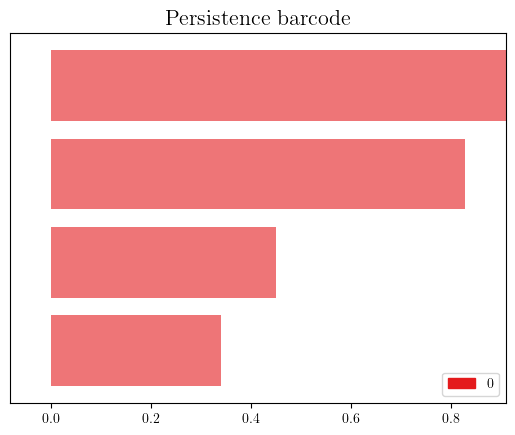

In [23]:
gd.plot_persistence_barcode(persistence = persistence_diagrams_1b[17])

In [18]:
persistence_diagrams_1b = []
for i in range(len(text)):
    persistence_diagrams_1b.append(persistent_homology_b[i])

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

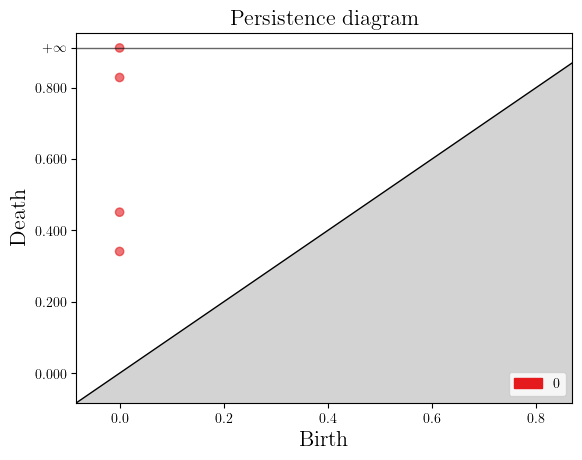

In [24]:
gd.plot_persistence_diagram(persistence = persistence_diagrams_1b[17])

### The Distance Matrix of Wasserstein Distances

Here we compute and print the pairwise Wasserstein distances between each pair of persistence diagrams for the phrase "לצפות בזרחת השמש" in the contexts `text[i]` for the context vectors computed by `TurkuNLP/wikibert-base-he-cased`. 

In [19]:
w_distances_b = compute_wasserstein_distances(persistence_diagrams_1b)
print(w_distances_b)

[[0.         2.38879104 4.32632676 2.80153121 2.18313677 2.2254028
  4.04470515 3.10831031 3.71425047 3.19170619 3.07076675 5.47013689
  6.79637232 4.32535843 2.37863109 2.0458142  6.43791491 7.04495738]
 [2.38879104 0.         2.86879539 2.56483239 1.24786971 3.70261807
  1.91333653 0.71951927 2.3277997  2.24007644 0.68197572 3.08134586
  4.71632238 1.9365674  2.20443168 2.38650018 4.04912387 5.06202639]
 [4.32632676 2.86879539 0.         5.25195835 3.97393705 4.38008389
  1.0971163  2.95578552 3.16765576 3.15477589 3.12895836 3.85571528
  3.42042416 1.13810161 4.88240481 3.17155104 4.29202261 3.37500445]
 [2.80153121 2.56483239 5.25195835 0.         1.31696268 5.02693401
  4.15730401 2.54117182 2.17483663 2.44318627 2.37200609 3.85448929
  5.62000253 4.41932688 1.04386132 3.71081612 4.8222673  6.07619064]
 [2.18313677 1.24786971 3.97393705 1.31696268 0.         3.9758797
  2.87928271 1.22420914 1.59447528 1.54824312 1.05504341 3.28700012
  5.05251336 3.1023642  1.61135048 2.65976181 

In [20]:
print(w_distances.shape)
print(w_distances - w_distances_b)


(18, 18)
[[ 0.         -2.34972695 -4.25864424 -2.78570614 -2.14543502 -2.17176301
  -3.89140906 -3.0489439  -3.66566315 -3.16006258 -3.03773667 -5.44226581
  -6.70286531 -4.30935988 -2.32683731 -2.00593682 -6.41192542 -7.01741918]
 [-2.34972695  0.         -2.80429269 -2.54159337 -1.21431745 -3.64233509
  -1.74921882 -0.62108877 -2.2647853  -2.20603202 -0.6346809  -3.02213911
  -4.62599519 -1.90118687 -2.13821083 -2.30755871 -4.01487248 -5.02809886]
 [-4.25864424 -2.80429269  0.         -5.19748415 -3.9281198  -4.30580608
  -0.91018913 -2.83654268 -3.1105495  -3.11873698 -3.09430592 -3.76016168
  -3.39217489 -1.08641764 -4.81147809 -3.06929007 -4.23717433 -3.27978373]
 [-2.78570614 -2.54159337 -5.19748415  0.         -1.29407077 -4.97515201
  -3.99079961 -2.46598035 -2.12549035 -2.42475097 -2.34431068 -3.81340989
  -5.53970384 -4.40718538 -0.99130859 -3.65511368 -4.7970768  -6.03544412]
 [-2.14543502 -1.21431745 -3.9281198  -1.29407077  0.         -3.90637293
  -2.69984067 -1.12714098

### Find Larger Wasserstein Distances

In [21]:
import numpy as np

def count_negative_entries_below_diagonal(matrix):
    count = 0
    total = 0
    n = len(matrix)
    for i in range(n):
        for j in range(i):
            if matrix[i][j] < 0:
                count += 1
            total += 1
    return count, total

# example matrix
matrix = w_distances - w_distances_b

negative_count, total_count = count_negative_entries_below_diagonal(matrix)
percentage = (negative_count / total_count) * 100
print("Percentage of negative entries below the diagonal: ", percentage)


Percentage of negative entries below the diagonal:  100.0


## Interpreting the results

So, as we can see, the percentage of negaive entries below the diagonal is approximately $100\%$, meaning $100\%$ of the time the Wasserstein distance between persistence diagrams for the phrase "לצפות בזרחת השמש" in various different contexts (given by the text corpera `text[i]` in `text` at the beginning of the notebook) is larger for `TurkuNLP/wikibert-base-he-cased` than for `dicta-il/alephbertgimmel-base`. This means that the `TurkuNLP/wikibert-base-he-cased` model does not preserve the persistent homology for the context vectors associated to the phrase "לצפות בזרחת השמש". In fact $100\%$ of the time `dicta-il/alephbertgimmel-base` has smaller Wasserstine distance between persistence diagrams than `TurkuNLP/wikibert-base-he-cased`. Note, this is comparing `head 3` of `layer 7` in the models. When we compare different heads this number will change and some heads drastically outperform others at preserving persistent homology of keyphrases. 

It is interesting to note that we might linguistically analyze a model's individual attention heads using this method to determine what kinds of keyphrases it preserves. We might also use this to modify attention heads to better understand certain keyphrases. This is closely linked to topic modeling as is mentioned in [Topics in Contextualised Attention Embeddings](https://arxiv.org/pdf/2301.04339.pdf). This, along with the Fréchet mean of persistence diagrams could also be used for anomaly detection, where an anomaly is considered a "significant" deviation from the Fréchet mean persistence diagram. For character level transformers this might also be used as a topological prior to obtain something like hierarchical morphological segmentations of words, where the hierarchy is given by the simplex tree, and the simplex tree is encouraged to mimic heirarchical morphological segmentation of words similar to what is described in [Morphological Segmentation Inside-Out](https://arxiv.org/abs/1911.04916v2). 